# Install Dependencies

In [51]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[other]
!pip install IPython

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


## Utilities Functions from the Lab sheets

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_result(episode_results, title=''):
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode ({})'.format(title))
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

def show_video_html():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')
    ipythondisplay.display(HTML(data='<video controls src="data:video/x-m4v;base64,{0}">'.format(encoded)))
  else:
    print("Could not find video")

## `Agent` Class
Defining a simple `Agent` Interface which consist of:

1. `step(action_space, observation)` - A single timestep where the agent can decide which action to take based on the current observation. The action return by the function will be executed by the environment.

2. `reward(immediate_reward, prev_action, prev_observation, new_observation)` - Updates the agent based on the immediate reward after performing the action given from `step`

3. `reset()` - Called when the episode ends and to reset the agent if needed

In [3]:
class Agent:

    def __init__(self):
        self.cumulative_reward = 0

    def step(self, action_space, observation):
        pass

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        pass

    def reset(self):
        pass


def run_episode(env, agent: Agent, show_video=False, evaluation = False):
    observation, info = env.reset()
    cumulative_reward = 0
    while True:
        action = agent.step(env.action_space, observation)
        new_observation, reward, terminated, truncated, info  = env.step(action)
        if terminated:
            reward = -10
        cumulative_reward += reward
        if not evaluation:
            agent.reward(reward, action, observation, new_observation)
        observation = new_observation
        if terminated or truncated:
            observation, info = env.reset()
            print("Cumulative reward for this round:", cumulative_reward)
            agent.reset()
            break
    if show_video:
        show_video_html()
    return cumulative_reward



## `RandomAgent` class

Here we define a `RandomAgent` by implementing `Agent` class
## Overridden methods:
1. `step` - Sample an action from the `action_space`



In [4]:
class RandomAgent(Agent):
    def step(self, action_space, observation):
        return action_space.sample()


Run the `RandomAgent` with 100 episodes

We can see that the cumulative reward is not increasing as expect from a `RandomAgent`

In [5]:
episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
random_agent = RandomAgent()
for i in range(100):
    episode_results.append(run_episode(env, random_agent))

/home/ciyfhx/miniforge3/envs/ai/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/ciyfhx/SC3000/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Cumulative reward for this round: 26.0
Cumulative reward for this round: 2.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 1.0
Cumulative reward for this round: 3.0
Cumulative reward for this round: 23.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 8.0
Cumulative reward for this round: 34.0
Cumulative reward for this round: 39.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 3.0
Cumulative reward for this round: 3.0
Cumulative reward for this round: -2.0
Cumulative reward for this round: 32.0
Cumulative reward for this round: 0.0
Cumulative reward for this round: 7.0
Cumulative reward for this round: 5.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 4.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 1

## **Value-Based** and **Policy-Based** methods
In Reinforcement Learning, RL algorithms are categorise into **Value-Based** and **Policy-Based** methods.

In **Value-Based** method, we parameterise the value function defined by the Bellman Equations and we try to find the optimal value function that will give us the optimal policy.

Example of **Value-Based** methods: Value Iterations, Policy Iteration (because the policy is defined by the state-action value function), SARSA (On-policy), Q-Learning (Off-Policy)

In **Policy-Based** method, we parameterise the policy directly instead and improve the policy directly without using the value function.

Example of **Policy-Based** methods: REINFORCE, Actor-Critic, PPO

We will be testing algorithms from both methods to learn from the environment. This exploration will help us understand the strengths and weaknesses of each approach and their applicability to different types of RL problems.

## Value-Based

## `QLearningControlAgent` Class

## Defining Q Learning (Off Policy Learning)

In Q Learning we do not need access to the MDP, no importance sampling and we do not need to wait for the episode to terminate for the Agent to start learning *See TD learning*.

### Formulation for Q Learning:

#### Policy (ε-greedy):

$
\pi(a \mid s) = 
\begin{cases} 
\arg\max_{a} Q(s, a) & \text{with probability } (1 - \epsilon), \\
\text{a random action} & \text{with probability } \epsilon.
\end{cases}
$

#### Update Rule:

$Q(S_{t},A_{t}) \gets Q(S_{t},A_{t}) + \alpha[R_{t+1} + \gamma max_{a}Q(S_{s+1},a)-Q(S_{t},A_{t})]$


**Important Note**: Q Learning is off policy because when we update the state action function we update toward:

$max_{a}Q(S_{s+1},a)$ 

Which is not always going to be the chosen action by the policy during training. Instead the ε-greedy policy may give choose a different action which makes the update rule independent from the policy itself.

Our learning rate and epsilon will have a log decay with a mininum lr and epsilon where $t$ is the episode.

$\text{learning\_rate} = \max \left( \text{min\_lr}, \min \left( 1, 1 - \log_{10} \left( \frac{t + 1}{\text{decay}} \right) \right) \right)$

$\text{epsilon} = \max \left( \text{min\_epsilon}, \min \left( 1, 1 - \log_{10} \left( \frac{t + 1}{\text{decay}} \right) \right) \right)$

## Overridden methods:
1. `step` - Select an action based on ε-greedy.
2. `reward` - Update the Q Table by using the update rule.


Episode: 0
Cumulative reward for this round: 1.0
Episode: 1
Cumulative reward for this round: 5.0
Episode: 2
Cumulative reward for this round: 9.0
Episode: 3
Cumulative reward for this round: 15.0
Episode: 4
Cumulative reward for this round: 21.0
Episode: 5
Cumulative reward for this round: 6.0
Episode: 6
Cumulative reward for this round: -1.0
Episode: 7
Cumulative reward for this round: 25.0
Episode: 8
Cumulative reward for this round: 23.0
Episode: 9
Cumulative reward for this round: 8.0
Episode: 10
Cumulative reward for this round: 33.0
Episode: 11
Cumulative reward for this round: 22.0
Episode: 12
Cumulative reward for this round: 5.0
Episode: 13
Cumulative reward for this round: 29.0
Episode: 14
Cumulative reward for this round: 4.0
Episode: 15
Cumulative reward for this round: 91.0
Episode: 16
Cumulative reward for this round: 6.0
Episode: 17
Cumulative reward for this round: 11.0
Episode: 18
Cumulative reward for this round: 0.0
Episode: 19
Cumulative reward for this round: 4.0


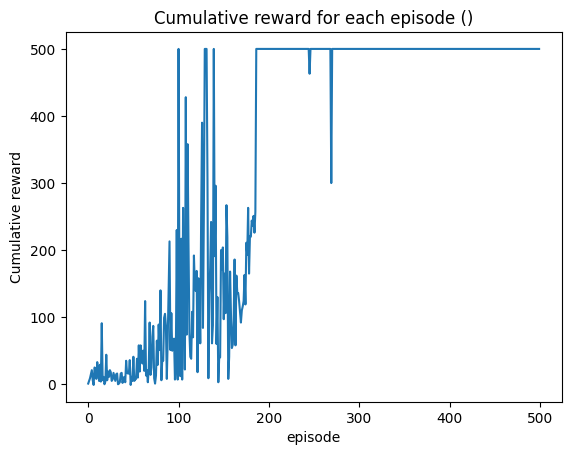

In [6]:
import numpy as np

# Model free
class QLearningControlAgent(Agent):

    def __init__(self,
        lower_bounds,
        upper_bounds,
        num_bins,
        num_action,
        min_epsilon=0.001, discount_factor=0.9, min_lr=0.1, decay=20,
    ):
        super().__init__()
        self.discount_factor = discount_factor
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.t = 0
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_bins = np.array(num_bins)
        self.qtable = np.zeros(np.append(self.num_bins + 1, num_action))

    def to_discrete_state(self, observation):
        '''
        We need to convert the continuous observation into discrete state by bining the values
        '''
        bin_window = (self.upper_bounds - self.lower_bounds) / self.num_bins
        clamped_observation = np.clip(observation, self.lower_bounds, self.upper_bounds)
        discrete_state = np.floor((clamped_observation - self.lower_bounds) / bin_window).astype(np.int32)
        return tuple(discrete_state)

    def get_learning_rate(self):
        return max(self.min_lr, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def get_epsilon(self):
        return max(self.min_epsilon, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def step(self, action_space, observation):
        state = self.to_discrete_state(observation)
        # Epsilon-greedy policy
        if np.random.random() < self.get_epsilon():
            action = np.random.randint(0, action_space.n)  # Random action
        else:
            action = np.argmax(self.qtable[state])  # Greedy action
        return action

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        prev_state = self.to_discrete_state(prev_observation)
        new_state = self.to_discrete_state(new_observation)
        self.qtable[prev_state + (prev_action,)] += self.get_learning_rate() * (immediate_reward + self.discount_factor * np.max(self.qtable[new_state]) - self.qtable[prev_state + (prev_action,)])

    def reset(self):
        self.t += 1

episode_results = []
env = gym.make("CartPole-v1", render_mode="rgb_array")
upper_bounds = np.array([env.observation_space.high[0], 0.5, env.observation_space.high[2], np.radians(50) / 1.]) # Upper bounds for our bining
lower_bounds = np.array([env.observation_space.low[0], -0.5, env.observation_space.low[2], - np.radians(50) / 1.]) # Lower bounds for our bining
qlearning_agent = QLearningControlAgent(lower_bounds, upper_bounds, [3, 3, 6, 6], env.action_space.n)
for i in range(500):
    print("Episode: " + str(i))
    episode_results.append(run_episode(env, qlearning_agent))

show_result(episode_results)

<H4> Imports for creating a Deep Q learning agent

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
from collections import deque

### Here we build a simple feed forward neural network using 512 neurons on first layer followed by 256 on the second layer, 64 on the third layer and finally the output layer.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
        )

    def forward(self, x):
        return self.model(x)

## `DeepQLearningAgent` Class

Defining Deep Q Learning (Off Policy Learning)

Deep Q Learning is an extension of Q Learning which replaces the Q Table with a deep neural network as a function approximator for the state-action function. DQN also uses a Replay Buffer to store past experiences.

Formulation for Deep Q Learning is similar to the Q Learning but the state-action function is now parameterise by $\theta$:

Policy (ε-greedy):

$
\pi(a \mid s) = 
\begin{cases} 
\arg\max_{a} Q_{\theta}(s, a) & \text{with probability } (1 - \epsilon), \\
\text{a random action} & \text{with probability } \epsilon.
\end{cases}
$

Update Rule:

$target \gets [R_{t+1} + \gamma max_{a}Q_{\theta, target\ network}(S_{s+1},a)]$

$\theta \leftarrow \theta - \alpha \nabla_{\theta} \left( \text{target} - Q_{\theta}(S_{t}, A_{t}) \right)^2$

*Note*: We will be using Adam Optimizer instead of a simple gradient descent

Overridden methods:

`step` - Select an action based on ε-greedy.

`reward` - Append the rewards, actions and observations to the Replay Buffer

`reset` - Update the nerual network from the Replay Buffer by using the update rule.

In [9]:
class DeepQLearningAgent(Agent):
    def __init__(self, state_size, action_size, min_epsilon=0.01, discount_factor=0.9, lr=0.0003, decay=3):
        super().__init__()

        # check for gpu accelerator
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )

        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.min_epsilon = min_epsilon
        self.lr = lr
        self.decay = decay
        self.t = 0
        self.epsilon = 1.0

        # here the agent keeps the previous experience
        self.memory = deque(maxlen=2000)
        self.batch_size = 64

        # the Q network will learn and update frequently from experience
        # while the target network will only update after a certain number of episodes
        self.q_network = NeuralNetwork(state_size, action_size).to(self.device)
        self.target_network = NeuralNetwork(state_size, action_size).to(self.device)
        self.update_target_network()

        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=self.lr, amsgrad=True)
        self.loss_fn = nn.MSELoss()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_epsilon(self):
        self.epsilon = max(self.min_epsilon, min(1., 1. - np.log10((self.t + 1) / self.decay)))
        return self.epsilon

    # here the agent either explore by choosing a random action
    # or exploit by choosing an action which give the highest Q value from the neural network
    def step(self, action_space, observation):
        if np.random.random() < self.get_epsilon():
            return np.random.randint(0, self.action_size)
        else:
            with torch.no_grad():
                observation = torch.tensor(observation, dtype=torch.float32, device=self.device)
                q_values = self.q_network(observation)
                return torch.argmax(q_values).item()

    # here when my agent interact with the cart pole environment it will take in a reward and new observation
    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        self.memory.append((prev_observation, prev_action, immediate_reward, new_observation))
        if len(self.memory) >= 1000 and self.epsilon != 0.0:
            self.replay_experience()

    def replay_experience(self):
        batch = random.sample(self.memory, self.batch_size)
        observation, actions, rewards, next_observation = zip(*batch)

        observation = torch.tensor(observation, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(dim=1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(dim=1)
        next_observation = torch.tensor(next_observation, dtype=torch.float32, device=self.device)

        current_q = self.q_network(observation).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.q_network(next_observation)
            next_actions = torch.argmax(next_q_values, dim=1, keepdim=True)
            max_next_q = self.target_network(next_observation).gather(1, next_actions)

        target_q = rewards + (self.discount_factor * max_next_q)

        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # here the function is called start of every episode
    # % 10 ensure target network is updated every 2 episodes to prevent instability to training
    def reset(self):
        self.t += 1
        if self.t % 2 == 0:
            self.update_target_network()

    # here we can save the model we just trained
    def save_model(self, file_path="models/deep_q_learning_agent.pth"):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Create directory if it doesn't exist
        torch.save(self.q_network.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    # here we can load the saved model for evaluation
    def load_model(self, file_path="models/deep_q_learning_agent.pth"):
        if os.path.exists(file_path):
            self.q_network.load_state_dict(torch.load(file_path, map_location=self.device))
            self.update_target_network()  # Ensure target network is also updated
            print(f"Model loaded from {file_path}")
        else:
            print(f"Model file '{file_path}' does not exist.")

    # set the agent to go for exploitation only without exploration
    def set_evaluation_mode(self):
        self.epsilon = 0.0
        self.q_network.eval()

<H4> Here we initialise the environement and the Deep Q learning agent

In [10]:
episode_results = []
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
deep_q_learning_agent = DeepQLearningAgent(state_size, action_size)

<H4> Here we train the agent, we will train the agent for 500 episode and saving the model at the end

Episode: 0
Cumulative reward for this round: 28.0
Episode: 1
Cumulative reward for this round: 3.0
Episode: 2
Cumulative reward for this round: 40.0
Episode: 3
Cumulative reward for this round: 6.0
Episode: 4
Cumulative reward for this round: 8.0
Episode: 5
Cumulative reward for this round: 4.0
Episode: 6
Cumulative reward for this round: 1.0
Episode: 7
Cumulative reward for this round: 4.0
Episode: 8
Cumulative reward for this round: 4.0
Episode: 9
Cumulative reward for this round: 5.0
Episode: 10
Cumulative reward for this round: 0.0
Episode: 11
Cumulative reward for this round: 0.0
Episode: 12
Cumulative reward for this round: -3.0
Episode: 13
Cumulative reward for this round: 1.0
Episode: 14
Cumulative reward for this round: -3.0
Episode: 15
Cumulative reward for this round: 0.0
Episode: 16
Cumulative reward for this round: -2.0
Episode: 17
Cumulative reward for this round: -1.0
Episode: 18
Cumulative reward for this round: 6.0
Episode: 19
Cumulative reward for this round: -2.0
Epi

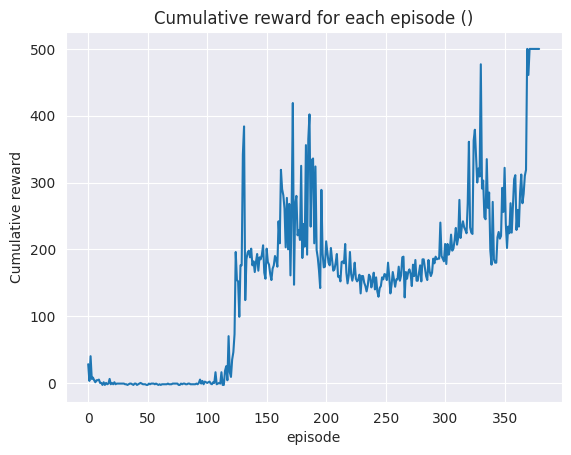

Model saved to models/deep_q_learning_agent.pth


In [138]:

counter = 0
for i in range(1000):
    print("Episode: " + str(i))
    cumulative_reward = run_episode(env, deep_q_learning_agent)
    episode_results.append(cumulative_reward)

    # Early stopping to prevent overfitting
    if cumulative_reward == 500:
        counter += 1
        if counter == 10:
            break

show_result(episode_results)

deep_q_learning_agent.save_model("models/deep_q_learning_agent.pth")


## Policy-Based

In **Policy-Based** method, we are trying to improve our policy directly.

Most **Policy-Based** method uses policy gradient techniques to improve the policy and **Policy Gradient Theorem** is central to this approach:

### **Policy Gradient Theorem**

The **Policy Gradient Theorem** provides a way to estimate the gradient of the expected cumulative reward $J(\theta)$ with respect to the policy parameters $\theta$.

$
\nabla_{\theta} J(\theta) = \mathbb{E}_{\pi_{\theta}} [ \nabla_{\theta} \log \pi_{\theta}(a | s) \cdot Q^{\pi_{\theta}}(s, a)]
$

Where $\nabla_{\theta} \log \pi_{\theta}(a | s)$ is the score function.

and $Q^{\pi_{\theta}}(s, a)$ is the long term reward following the policy parameterise by $\theta$.

## `REINFORCEAgent` Class

Defining Monte-Carlo Policy Gradient (REINFORCE)

REINFORCE is a simple **Policy-Based** method which use the **Policy Gradient Theorem** to improve the policy. The algorithm will **maximize the cumulative reward** from the policy objective function using gradient ascent.

Policy (Softmax Policy):

$
\pi_{\theta}(a | s) = \frac{e^{f_{\theta}(s, a)}}{\sum_{a'} e^{f_{\theta}(s, a')}}
$

Update Rule:

$\nabla_{\theta} J(\theta) = \mathbb{E}_{\pi_{\theta}} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) G_t \right]$

$\theta \leftarrow \theta + \alpha \left( \nabla_{\theta} J(\theta) \right)$

*Note*: We will be using Adam Optimizer instead of a simple gradient ascent

Overridden methods:

`step` - Select an action based on Softmax Policy. 

`reward` - Append the rewards, actions and observations

`reset` - Update the policy after the episode ends using the update rule and clear the appended rewards, actions and observations


In [11]:
import torch.nn.functional as F

class REINFORCEAgent(Agent):
    def __init__(self, state_size, action_size, discount_factor=0.9, lr=0.0003):
        super().__init__()

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.episodes = []
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.lr = lr
        self.evaluation = False

        self.policy = NeuralNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.lr, amsgrad=True)
        self.loss_fn = nn.MSELoss()

    def discount_rewards(self, rewards, gamma):
        discounted = []
        cumulative_reward = 0.0
        for reward in reversed(rewards):
            cumulative_reward = reward + gamma * cumulative_reward
            discounted.insert(0, cumulative_reward)
        return discounted

    def step(self, action_space, observation):
        observation = torch.tensor(observation, dtype=torch.float32, device=self.device)
        action_probs = F.softmax(self.policy(observation), dim=0)
        action_distribution = torch.distributions.Categorical(action_probs)
        action = action_distribution.sample()
        return action.item()
    
    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        self.episodes.append((prev_observation, prev_action, immediate_reward))

    def update(self):
        discounted_rewards = self.discount_rewards(list(zip(*self.episodes))[2], self.discount_factor)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=self.device)

        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

        policy_loss = []
        for (observation, action, immediate_reward), discounted_reward in zip(self.episodes, discounted_rewards):
            observation = torch.tensor(observation, dtype=torch.float32, device=self.device)
            action_probs = F.softmax(self.policy(observation), dim=0)
            log_prob = torch.log(action_probs[action])
            policy_loss.append(-log_prob * discounted_reward) # Gradient Ascent

        policy_loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.episodes = []

    def reset(self):
        if not self.evaluation:
            self.update()

    def save_model(self, file_path="models/reinforce_learning_agent.pth"):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Create directory if it doesn't exist
        torch.save(self.policy.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path="models/reinforce_learning_agent.pth"):
        if os.path.exists(file_path):
            self.policy.load_state_dict(torch.load(file_path, map_location=self.device))
            print(f"Model loaded from {file_path}")
        else:
            print(f"Model file '{file_path}' does not exist.")

    def set_evaluation_mode(self):
        self.evaluation = True

Episode: 0
Cumulative reward for this round: 7.0
Episode: 1
Cumulative reward for this round: 8.0
Episode: 2
Cumulative reward for this round: 32.0
Episode: 3
Cumulative reward for this round: 23.0
Episode: 4
Cumulative reward for this round: 8.0
Episode: 5
Cumulative reward for this round: 11.0
Episode: 6
Cumulative reward for this round: 17.0
Episode: 7
Cumulative reward for this round: 19.0
Episode: 8
Cumulative reward for this round: 11.0
Episode: 9
Cumulative reward for this round: 23.0
Episode: 10
Cumulative reward for this round: 13.0
Episode: 11
Cumulative reward for this round: 17.0
Episode: 12
Cumulative reward for this round: 21.0
Episode: 13
Cumulative reward for this round: 49.0
Episode: 14
Cumulative reward for this round: 19.0
Episode: 15
Cumulative reward for this round: 8.0
Episode: 16
Cumulative reward for this round: 21.0
Episode: 17
Cumulative reward for this round: 15.0
Episode: 18
Cumulative reward for this round: 20.0
Episode: 19
Cumulative reward for this round:

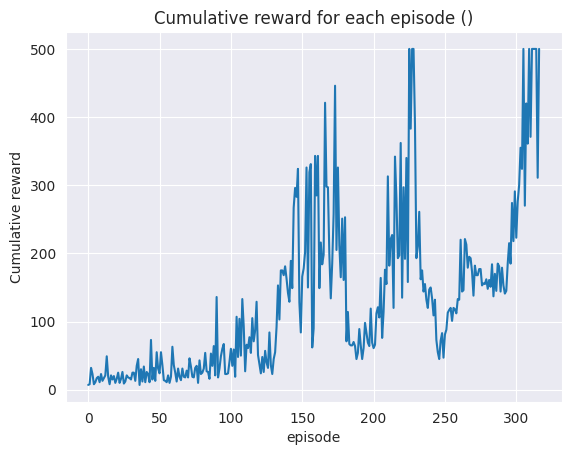

Model saved to models/reinforce_learning_agent.pth


In [76]:
episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
reinforce_agent = REINFORCEAgent(state_size, action_size)

counter = 0
for i in range(500):
    print("Episode: " + str(i))
    cumulative_reward = run_episode(env, reinforce_agent)
    episode_results.append(cumulative_reward)

    # Early stopping to prevent overfitting
    if cumulative_reward == 500:
        counter += 1
        if counter == 10:
            break

show_result(episode_results)
reinforce_agent.save_model()

# Task 1

## Here we sample a random state of the cart pole enviroment to input into our current agent which will output a action to check if our action is correct, we also show the image of the current state to better visualise

Model file 'models/deep_q_learning_agent.pth' does not exist.
Observation: [-0.01674644  0.01189647  0.0430618  -0.03078089]
Action: 1


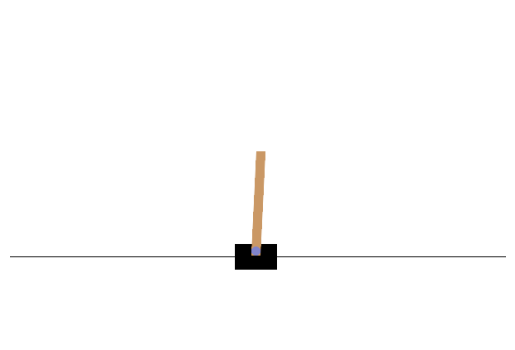

In [62]:
deep_q_learning_agent.load_model("models/deep_q_learning_agent.pth")
deep_q_learning_agent.set_evaluation_mode()

observation, info = env.reset()
image = env.render()

action = deep_q_learning_agent.step(env.action_space, observation)
print("Observation: " + str(observation))
print("Action: " + str(action))

import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis('off')
plt.show()

<H2> Task 2

## Here we load our previously saved 3 models for evaluation
- Q Learning
- Deep Q Learning
- REINFORCE Learning

Episode: 0
Cumulative reward for this round: 500.0
Episode: 1
Cumulative reward for this round: 500.0
Episode: 2
Cumulative reward for this round: 500.0
Episode: 3
Cumulative reward for this round: 500.0
Episode: 4
Cumulative reward for this round: 500.0
Episode: 5
Cumulative reward for this round: 500.0
Episode: 6
Cumulative reward for this round: 500.0
Episode: 7
Cumulative reward for this round: 500.0
Episode: 8
Cumulative reward for this round: 500.0
Episode: 9
Cumulative reward for this round: 500.0
Episode: 10
Cumulative reward for this round: 500.0
Episode: 11
Cumulative reward for this round: 500.0
Episode: 12
Cumulative reward for this round: 500.0
Episode: 13
Cumulative reward for this round: 500.0
Episode: 14
Cumulative reward for this round: 500.0
Episode: 15
Cumulative reward for this round: 500.0
Episode: 16
Cumulative reward for this round: 500.0
Episode: 17
Cumulative reward for this round: 500.0
Episode: 18
Cumulative reward for this round: 500.0
Episode: 19
Cumulative

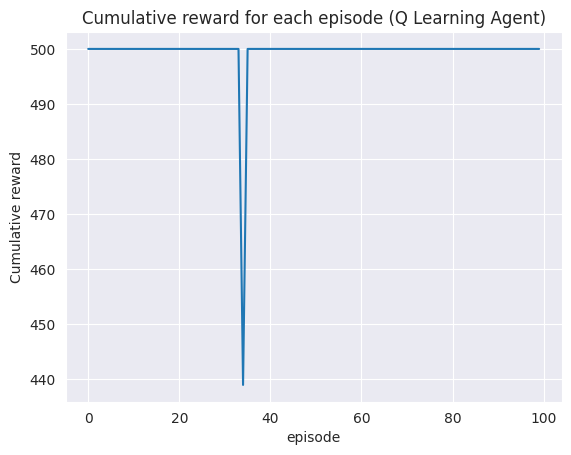

Model loaded from models/deep_q_learning_agent.pth
Episode: 0
Cumulative reward for this round: 500.0
Episode: 1
Cumulative reward for this round: 500.0
Episode: 2
Cumulative reward for this round: 500.0
Episode: 3
Cumulative reward for this round: 500.0
Episode: 4
Cumulative reward for this round: 310.0
Episode: 5
Cumulative reward for this round: 500.0
Episode: 6
Cumulative reward for this round: 500.0
Episode: 7
Cumulative reward for this round: 269.0
Episode: 8
Cumulative reward for this round: 500.0
Episode: 9
Cumulative reward for this round: 500.0
Episode: 10
Cumulative reward for this round: 287.0
Episode: 11
Cumulative reward for this round: 500.0
Episode: 12
Cumulative reward for this round: 294.0
Episode: 13
Cumulative reward for this round: 500.0
Episode: 14
Cumulative reward for this round: 243.0
Episode: 15
Cumulative reward for this round: 500.0
Episode: 16
Cumulative reward for this round: 500.0
Episode: 17
Cumulative reward for this round: 500.0
Episode: 18
Cumulative 

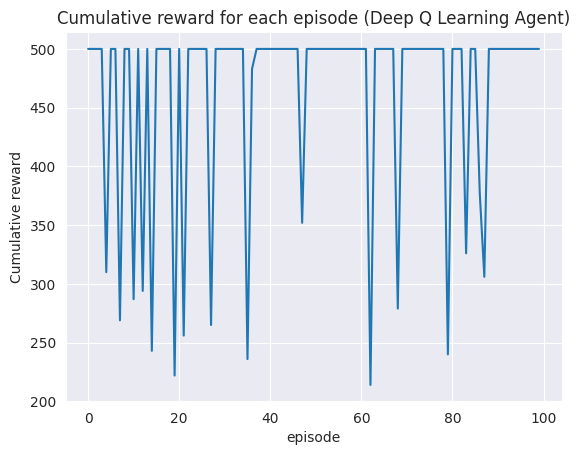

In [139]:
# Evaluation for Q Learning Agent
evaluation_results = []
for i in range(100):
    print("Episode: " + str(i))
    cumulative_reward = run_episode(env, qlearning_agent, evaluation=True)
    evaluation_results.append(cumulative_reward)

print("Average cumulative reward: " + str(np.mean(evaluation_results)))
print("Is my agent good enough: " + str(np.mean(evaluation_results) > 195))
show_result(evaluation_results, "Q Learning Agent")


# Evaluation for Deep Q Learning Agent
deep_q_learning_agent.load_model("models/deep_q_learning_agent.pth")
deep_q_learning_agent.set_evaluation_mode()

evaluation_results = []
for i in range(100):
    print("Episode: " + str(i))
    cumulative_reward = run_episode(env, deep_q_learning_agent, evaluation=True)
    evaluation_results.append(cumulative_reward)

print("Average cumulative reward: " + str(np.mean(evaluation_results)))
print("Is my agent good enough: " + str(np.mean(evaluation_results) > 195))
show_result(evaluation_results, "Deep Q Learning Agent")

Model loaded from models/reinforce_learning_agent.pth
Cumulative reward for this round: 473.0
Evaluation Episode 1: Reward = 473.0
Cumulative reward for this round: 500.0
Evaluation Episode 2: Reward = 500.0
Cumulative reward for this round: 500.0
Evaluation Episode 3: Reward = 500.0
Cumulative reward for this round: 500.0
Evaluation Episode 4: Reward = 500.0
Cumulative reward for this round: 500.0
Evaluation Episode 5: Reward = 500.0
Cumulative reward for this round: 485.0
Evaluation Episode 6: Reward = 485.0
Cumulative reward for this round: 500.0
Evaluation Episode 7: Reward = 500.0
Cumulative reward for this round: 500.0
Evaluation Episode 8: Reward = 500.0
Cumulative reward for this round: 349.0
Evaluation Episode 9: Reward = 349.0
Cumulative reward for this round: 500.0
Evaluation Episode 10: Reward = 500.0
Cumulative reward for this round: 389.0
Evaluation Episode 11: Reward = 389.0
Cumulative reward for this round: 500.0
Evaluation Episode 12: Reward = 500.0
Cumulative reward f

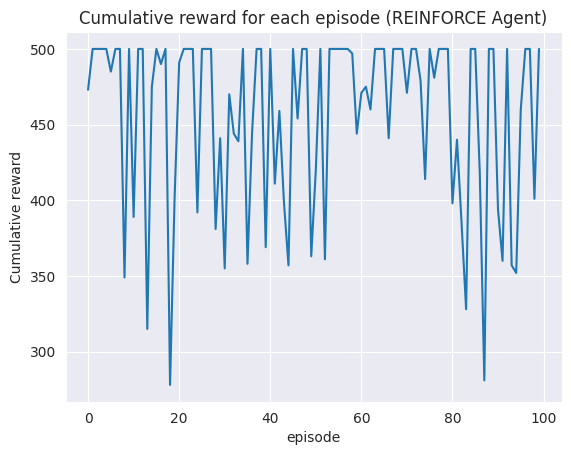

In [77]:
# Evaluation for REINFORCE Agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
reinforce_agent = REINFORCEAgent(state_size, action_size)
reinforce_agent.set_evaluation_mode()
reinforce_agent.load_model("models/reinforce_learning_agent.pth")
evaluation_results = []
for i in range(100):
    cumulative_reward = run_episode(env, reinforce_agent, evaluation=True)
    evaluation_results.append(cumulative_reward)
    print(f"Evaluation Episode {i+1}: Reward = {cumulative_reward}")

print("Average cumulative reward: " + str(np.mean(evaluation_results)))
print("Is my agent good enough: " + str(np.mean(evaluation_results) > 195))
show_result(evaluation_results, "REINFORCE Agent")

<H2> Task 3

<H4> Here we will render 1 episode played by the agent and output the cumlative reward

In [33]:
deep_q_learning_agent.load_model("models/deep_q_learning_agent.pth")
deep_q_learning_agent.set_evaluation_mode()

env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
run_episode(env, deep_q_learning_agent, evaluation=True, show_video=True)

Model loaded from models/deep_q_learning_agent.pth
Cumulative reward for this round: 500.0


500.0

### Conclusion

In this assignment, we implemented three different RL algorithms; Q Learning, Deep Q Learning and REINFORCE. 